In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
import math
# univariate bidirectional lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
log_ddf=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods.csv").drop(["Unnamed: 0"], axis=1)

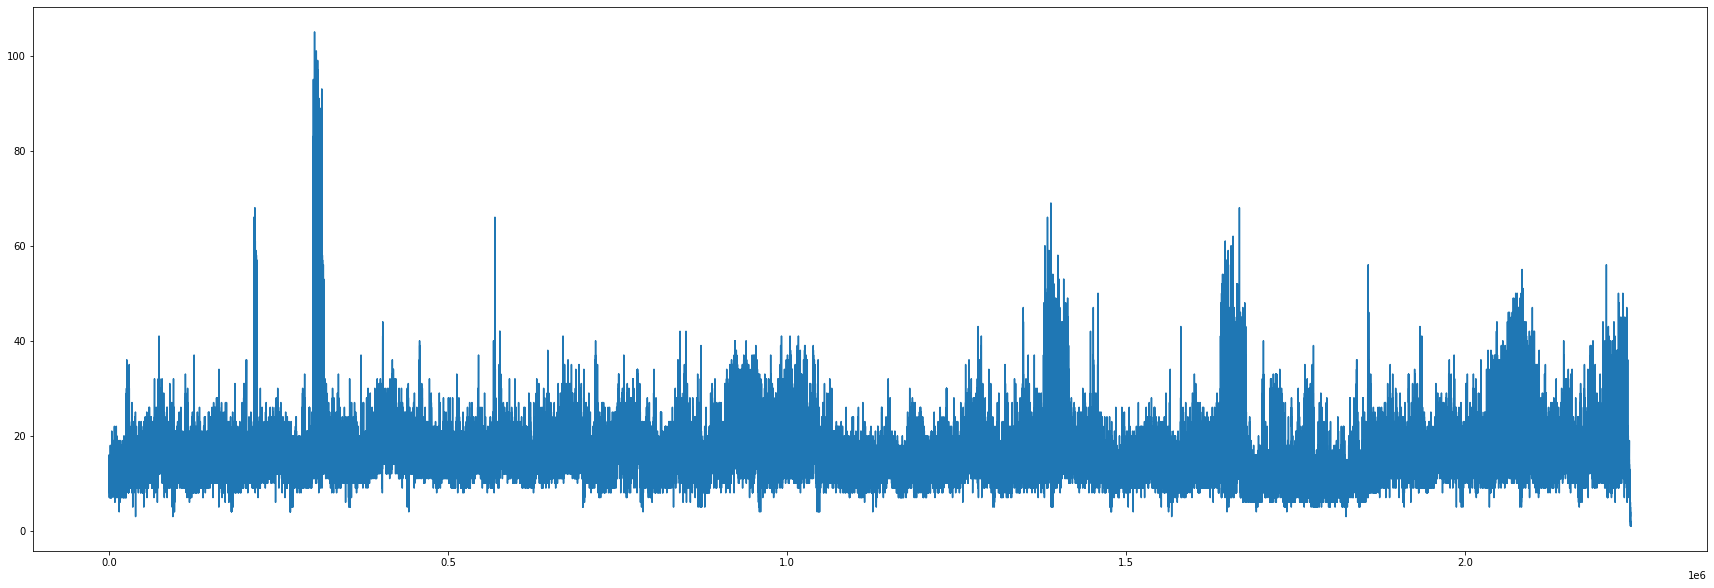

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(log_ddf['pods'])

plt.show()

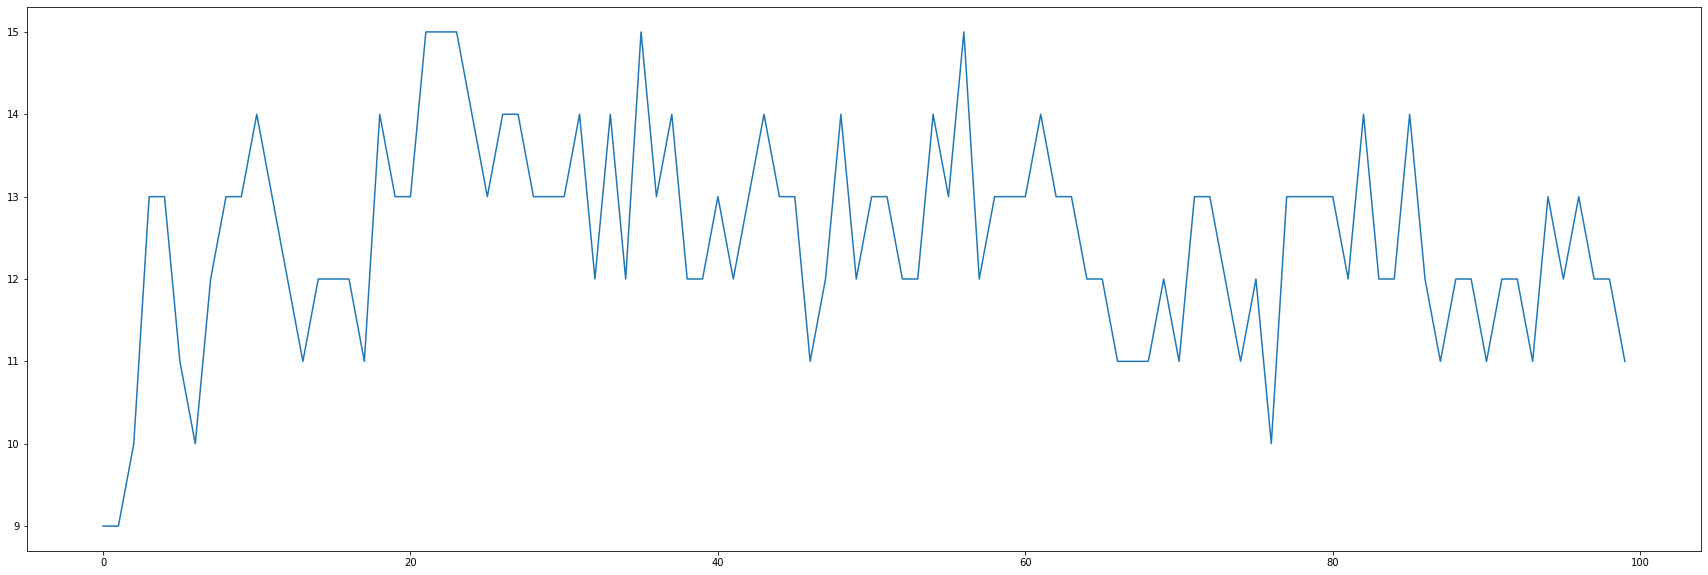

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(log_ddf['pods'][:100])

plt.show()

In [ ]:
# univariate bidirectional lstm
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional

from sklearn.metrics import mean_squared_error

### split a univariate sequence

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        #Reshape data from (history_size,) to (history_size,1)
        data.append(np.reshape(dataset[indices], (history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [ ]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
def shape_seq(raw_seq, n_steps, n_features):
    # raw_seq=list(log_ddf_null['ip'])[:60480]

    # choose a number of time steps
    # n_steps = 30
    
    # split into samples
    X, y = split_sequence(raw_seq, n_steps)
    print('split sequence: ', X.shape, y.shape)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    # n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    
    print('reshape: ', X.shape, y.shape)
    
    return X, y

### input

In [ ]:
log_ddf['datetime']=pd.to_datetime(log_ddf['datetime'])
log_ddf=log_ddf.set_index(log_ddf['datetime'])
log_df_index=log_ddf.drop(['datetime'], axis=1)

In [ ]:
def set_model(X, y, n_steps, n_features, epochs, verbose, X_val, y_val):
    # # define model
    # model = Sequential()

    # # 다음 레이어에도 순환신경망이 나오는 경우, return_sequences = True로 설정하면 에러가 나지 않음
    # # Dense로 연결하는 경우 : return_sequences = False
    # model.add(Bidirectional(LSTM(50), input_shape=(n_steps, n_features)))
    # model.add(Dense(1))
    # model.compile(optimizer='adam', loss='mse')
    # # fit model
    # hist=model.fit(X, y, epochs=epochs, verbose=verbose)
    with tf.device('/device:GPU:0'):
      model = tf.keras.models.Sequential([
          Bidirectional(LSTM(200, return_sequences=True), input_shape=(n_steps, n_features)),
          Dense(256, activation='tanh'),
          Bidirectional(tf.keras.layers.LSTM(200)),
          tf.keras.layers.Dropout(0.4),
          Dense(256, activation='tanh'),
          Dense(256, activation='tanh'),
          tf.keras.layers.Dropout(0.4),
          Dense(256, activation='tanh'),
          Dense(256, activation='tanh'),
          tf.keras.layers.Dropout(0.4),
          Dense(256, activation='tanh'),
          Dense(256, activation='tanh'),
          tf.keras.layers.Dropout(0.4),
          Dense(256, activation='tanh'),
          Dense(256, activation='tanh'),
          tf.keras.layers.Dropout(0.4),
          Dense(units=n_steps),
      ])
      model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
      model.summary() 
    
      model_path = 'model.h5'
      early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
      checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
      callbacks=[early_stopings,checkpoint]
      hist=model.fit(X, y, epochs=epochs,steps_per_epoch=100,callbacks=callbacks, verbose=verbose,validation_data=(X_val, y_val), validation_steps=20)
      return model

In [ ]:
def get_mse(test_data, model, n_steps, n_features):
    # demonstrate prediction
    data_size=len(test_data)
    
    predict_list=[]

    for i in range(data_size-n_steps):
        x_input = array(test_data[i:i+n_steps])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predict_list.append([i+n_steps, yhat[0][0]])
    
    return mean_squared_error(test_data[n_steps:], pd.DataFrame(predict_list)[1])

In [ ]:
def process(data, cols, time_sample, n_steps, n_features, epochs, size, verbose,batch_size = 128, buffer_size = 150):
    mse_df=pd.DataFrame(columns=list(cols), index=list(time_sample))
    for t in time_sample:
        for i in range(2):
            if i==0:
                df=pd.DataFrame(data.resample(t).min());
            elif i==1:
                df=pd.DataFrame(data.resample(t).max());  
            # elif i==2:
            #     df=pd.DataFrame(data.resample(t).mean());

            X, y=univariate_data(array(df['pods']), 0, size, n_steps, n_features)
            #train_data = tf.data.Dataset.from_tensor_slices((X, y))
            #train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
            
            X_val, y_val=univariate_data(array(df['pods']), size, 30000, n_steps, n_features, single_step=True)
            #val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
            #val_data = val_data.batch(batch_size).repeat()  
                     
            model=set_model(X, y, n_steps, n_features, epochs, verbose, X_val, y_val)
            mse=get_mse(array(list(df['pods'])[size:30000]), model, n_steps, n_features)
            mse_df[cols[i]][t]=mse
            print("MSE ['%s']['%s'] : %f\n--------------------------------------\n"%(cols[i], t, mse))
    min_val=100000
    min_time=''
    min_col=''
    for i in range(len(cols)):
        for j in range(len(time_sample)):
            if mse_df[cols[i]][time_sample[j]]<min_val:
                min_val=mse_df[cols[i]][time_sample[j]]
                min_time=time_sample[j]
                min_col=cols[i]
    print(mse_df)
    print("\n--------------------------------------\nMin MSE: %f, time: %s, col: %s"%(min_val, min_time, min_col))

In [ ]:
data=log_df_index['pods']
cols=["min","mean"] #, "median", "first", "last"]
time_sample=['0.2T','0.5T','1T'] #, '2T','3T','4T','5T']
n_steps=10
n_features=1
epochs=200
size=25000
verbose=1
process(data, cols, time_sample, n_steps, n_features, epochs, size, verbose)

TypeError: ignored

## Best Model

Min MSE: 0.000560, time: 1T, col: min

Min MSE: 0.014447, time: 0.5T, col: mean

Min MSE: 3.724641, time: 0.5T, col: min

Min MSE: 1514.238678, time: 0.5T, col: min

Min MSE: 6.012716, time: 0.5T, col: min

In [ ]:
df.index=df['datetime']
data=df['pods']
cols="min"
time_sample='0.5T'
n_steps=10
n_features=1
epochs=300
size=25000
verbose=1
batch_size = 128
buffer_size = 150

df=pd.DataFrame(data.resample(time_sample).mean());


X, y=univariate_data(array(df['pods']), 0, size, n_steps, n_features)
# train_data = tf.data.Dataset.from_tensor_slices((X, y))
# train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()

X_val, y_val=univariate_data(array(df['pods']), size, 30000, n_steps, n_features)
# val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# val_data = val_data.batch(batch_size).repeat()  
           
with tf.device('/device:GPU:0'):
  model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=(n_steps, n_features)),
      Dense(512, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(512, activation='tanh'),
      Dense(512, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(512, activation='tanh'),
      Dense(512, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(512, activation='tanh'),
      Dense(512, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(512, activation='tanh'),
      Dense(512, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(units=n_steps),
  ])
  model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
  model.summary() 

  model_path = 'model.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  hist=model.fit(X, y, epochs=epochs,steps_per_epoch=100,callbacks=callbacks, verbose=verbose,validation_data=(X_val, y_val), validation_steps=20, shuffle=False)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 10, 400)          323200    
 nal)                                                            
                                                                 
 dense_31 (Dense)            (None, 10, 512)           205312    
                                                                 
 bidirectional_7 (Bidirectio  (None, 400)              1140800   
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 400)               0         
                                                                 
 dense_32 (Dense)            (None, 512)               205312    
                                                                 
 dense_33 (Dense)            (None, 512)              

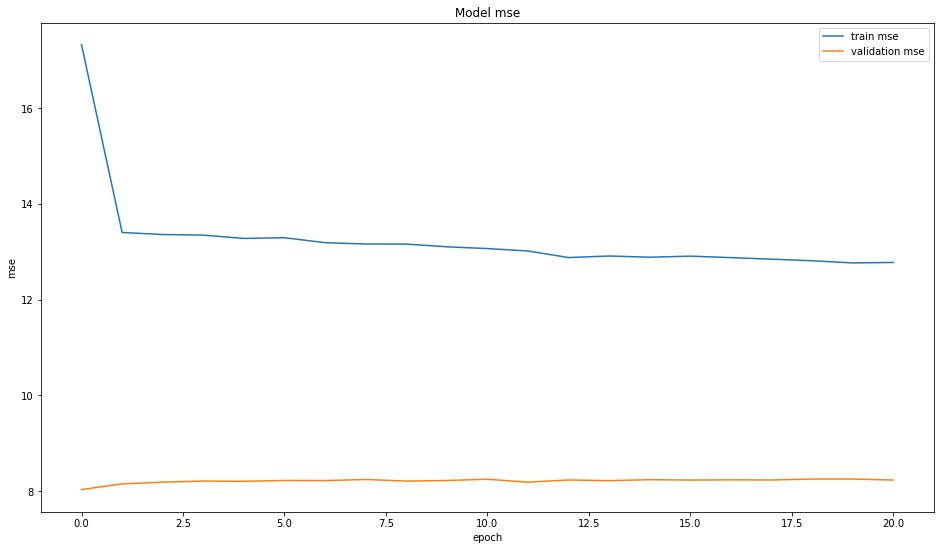

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train mse', 'validation mse'])
plt.show()

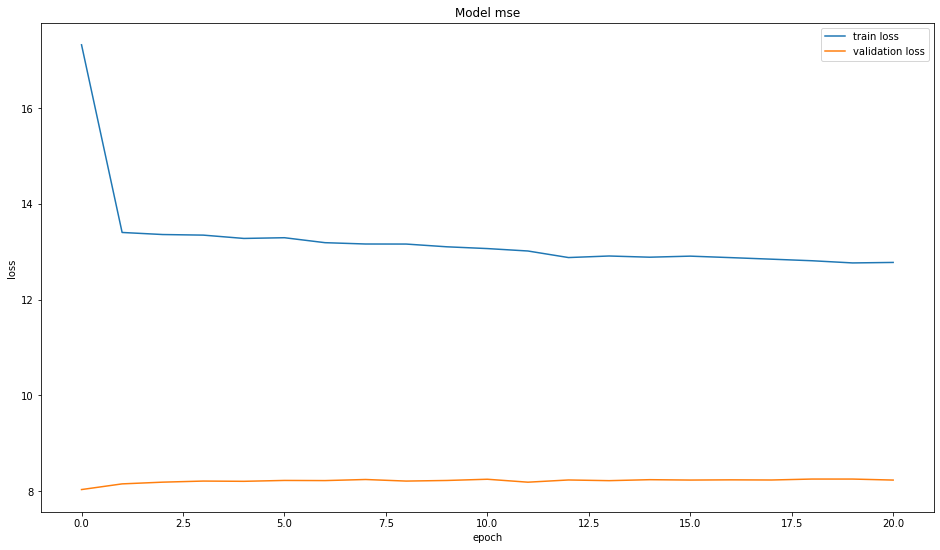

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

### plt

In [ ]:
def plot_input(test_data, model, n_steps, n_features):
    # demonstrate prediction
    data_size=len(test_data)
    
    predict_list=[]

    for i in range(data_size-n_steps):
        x_input = array(test_data[i:i+n_steps])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predict_list.append([i+n_steps, yhat[0][0]])

    plt.figure(figsize=(30,10))
    plt.plot(list(test_data))
    plt.plot(pd.DataFrame(predict_list)[0], pd.DataFrame(predict_list)[1])
    #plt.plot(30, yhat, marker="H")
    plt.show()
    
    print("MSE: "+str(mean_squared_error(test_data[n_steps:], pd.DataFrame(predict_list)[1])))

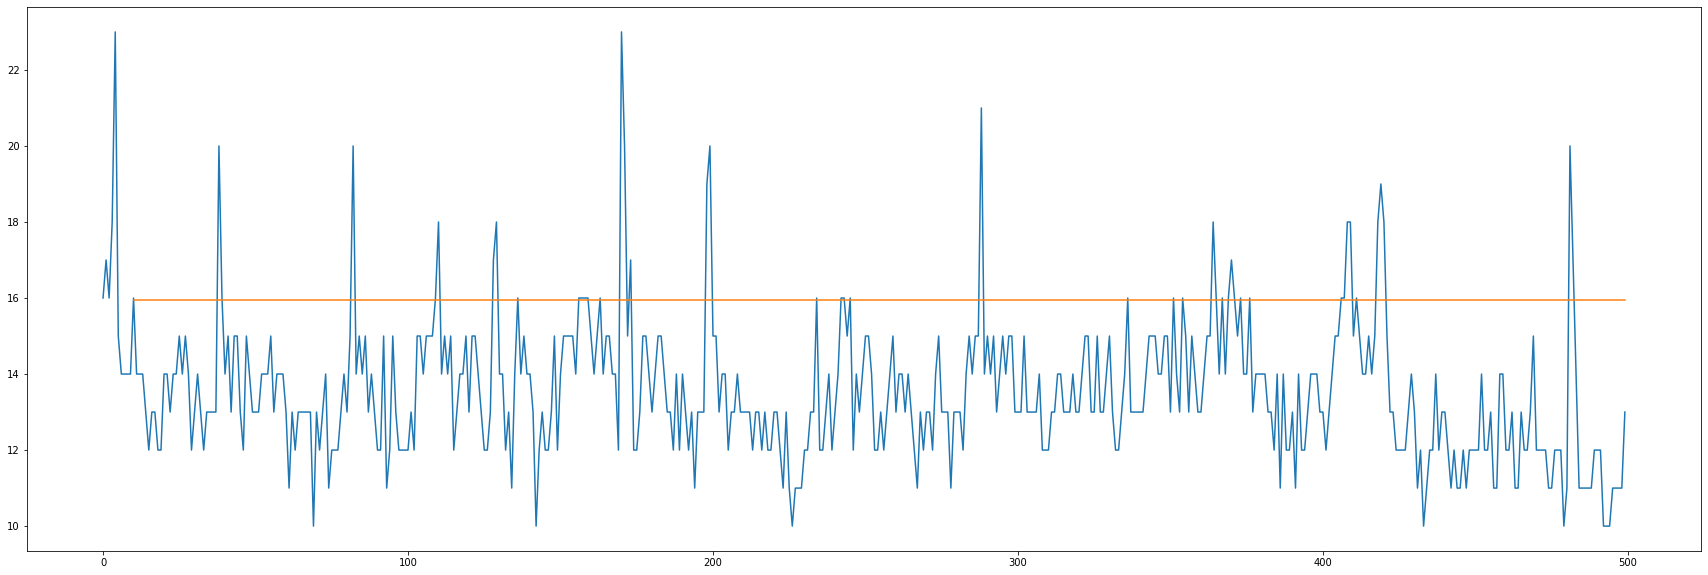

MSE: 8.980117946391164


In [ ]:
test_data=list(log_df_index['pods'])[60500:61000]
predict_list=plot_input(test_data, model, n_steps, n_features)

# OneHot으로 예측
- 실패함(오버피팅 해결 못함)

### split to one hot

In [ ]:
log_ddf=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods.csv").drop(["Unnamed: 0"], axis=1)
log_ddf['datetime']=pd.to_datetime(log_ddf['datetime'])
log_ddf=log_ddf.set_index(log_ddf['datetime'])
log_df_index=log_ddf.drop(['datetime'], axis=1)

In [ ]:
def split_onehot(dataset, target, start, end, window, horizon, single_step=False):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    if single_step:
        y.append(target[i+horizon])
    else:
        y.append(target[i:i+horizon])
  return np.array(X), np.array(y) 

In [ ]:
def process_onehot(data, cols, time_sample, n_steps, n_features, epochs, size, verbose,batch_size = 128, buffer_size = 150):
    mse_df=pd.DataFrame(columns=list(cols), index=list(time_sample))
    target=data[['pods']]
    data.drop(['pods'], axis=1, inplace=True)
    for t in time_sample:
        for i in range(3):
            if i==0:
                df=pd.DataFrame(data.resample(t).min())
            elif i==1:
                df=pd.DataFrame(data.resample(t).last())  
            elif i==2:
                df=pd.DataFrame(data.resample(t).median())

            #X, y=shape_seq(array(list(df['pods'])[:size]), n_steps, n_features)
            X, y=split_onehot(array(df), array(target), 0, size, n_steps, n_features)
            
            train_data = tf.data.Dataset.from_tensor_slices((X, y))
            train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
            
            #X_val, y_val=shape_seq(array(list(df['pods'])[size:10000]), n_steps, n_features)
            X_val, y_val=split_onehot(array(df), array(target), size, None, n_steps, n_features, single_step=True)
            
            val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
            val_data = val_data.batch(batch_size).repeat()  
                     
            #model=set_model(train_data, n_steps, n_features, epochs, verbose, val_data)

            with tf.device('/device:GPU:0'):
                  model = tf.keras.models.Sequential([
                      Bidirectional(LSTM(200, return_sequences=True), input_shape=X.shape[-2:]),
                      Dense(128, activation='tanh'),
                      Bidirectional(tf.keras.layers.LSTM(200)),
                      tf.keras.layers.Dropout(0.4),
                      Dense(128, activation='tanh'),
                      Dense(128, activation='tanh'),
                      tf.keras.layers.Dropout(0.4),
                      Dense(128, activation='tanh'),
                      Dense(128, activation='tanh'),
                      tf.keras.layers.Dropout(0.4),
                      
                      Dense(units=n_steps),
                  ])
                  model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], run_eagerly=True)#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
                  model.summary() 
                
                  model_path = 'model.h5'
                  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
                  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
                  callbacks=[early_stopings,checkpoint]

                  hist=model.fit(train_data, epochs=epochs, callbacks=callbacks, verbose=verbose,validation_data=val_data, validation_steps=20, steps_per_epoch=200)

                  return hist, model, val_data


In [ ]:
data=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1) 
cols=["min"] #, "last", "median"]
time_sample=['0.5T'] # ['0.2T','0.5T','0.75T','1T'] #, '2T','3T','4T','5T']
n_steps=5
n_features=1
epochs=100
size=68000
verbose=1
hist, model, val_data=process_onehot(data, cols, time_sample, n_steps, n_features, epochs, size, verbose)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 400)           481600    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5, 128)            51328     
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               51328     
                                                                 
 dense_2 (Dense)             (None, 128)               1

KeyboardInterrupt: ignored

In [ ]:
data=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1) 
target=data[['pods']]
data.drop(['pods'], axis=1, inplace=True)
df=pd.DataFrame(data.resample('0.5T').min())

X, y=split_onehot(array(df), array(target), 0, size, n_steps, n_features)
X[:5].shape

In [ ]:
X.shape

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['rmse'])
plt.plot(hist.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
# def plot_input(test_data, model, n_steps, n_features, batch_size = 128, buffer_size = 150):
#     # demonstrate prediction
#     data_size=len(test_data)
    
#     predict_list=[]

#     target=test_data[['pods']]
#     test_data.drop(['pods'], axis=1, inplace=True)

#     X, y = split_onehot(array(test_data), array(target), 0, None, n_steps, n_features)
#     # test = tf.data.Dataset.from_tensor_slices((X, y))
#     # test = test.cache().shuffle(buffer_size).batch(batch_size).repeat()

#     for i in range(data_size-n_steps-1):
#         x_input = array(X[i])
#         x_input = x_input.reshape((1, n_steps, data_size))
#         yhat = model.predict(x_input, verbose=0)
#         predict_list.append([yhat[0][0]])

#     # print(y.shape)
#     # yhat = model.predict(X, verbose=0)

#     # for i in range(data_size-n_steps):
#     #   predict_list.append([yhat[i][0]])

#     # print(pd.DataFrame(y.reshape((y.shape[-3],)), columns=['y'])['y'])

#     plt.figure(figsize=(30,10))
#     plt.plot(pd.DataFrame(predict_list)[0])
#     plt.plot(pd.DataFrame(y.reshape((y.shape[-3],)), columns=['y'])['y'])
#     #plt.plot(30, yhat, marker="H")
#     plt.show()


def plot_input(test_data, model, n_steps, n_features):
    # demonstrate prediction
    data_size=len(test_data)
    
    predict_list=[]

    target=test_data['pods']
    test_data.drop(['pods'], axis=1, inplace=True)

    # X, y = split_onehot(array(test_data), array(target), 0, None, n_steps, n_features)

    for i in range(data_size-n_steps):
        x_input = array(test_data[i:i+n_steps])
        x_input = x_input.reshape((1, 5, 100))
        yhat = model.predict(x_input, verbose=0)
        predict_list.append([i+n_steps, yhat[0][0]])

    plt.figure(figsize=(30,10))
    plt.plot(list(target))
    plt.plot(pd.DataFrame(predict_list)[0], pd.DataFrame(predict_list)[1])
    #plt.plot(30, yhat, marker="H")
    plt.show()
    
    #print("MSE: "+str(mean_squared_error(test_data[n_steps:], pd.DataFrame(predict_list)[1])))

In [ ]:
# 한 번에 예측하면 안 된다고 했음

# test_data=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1).iloc[30000:30100]
# predict_list=plot_input(test_data, model, n_steps, n_features)

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [ ]:
data=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1) 
data=pd.DataFrame(data.resample(t).min())
n_steps=5
n_features=1
size=68000
x_test_single, y_test_single =split_onehot(array(data.drop(['pods'], axis=1)), array(data[['pods']]), size, None, n_steps, n_features, single_step=True)

In [ ]:
pred = model.predict(x_test_single)

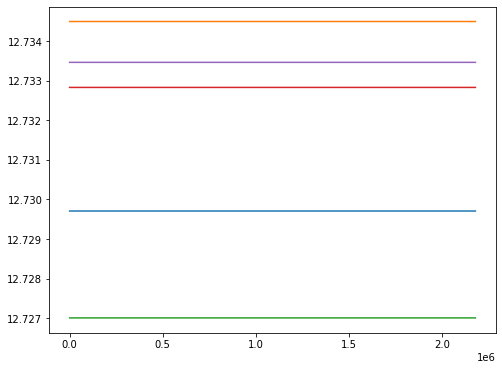

In [ ]:
plt.plot(pred)

In [ ]:
val_data

<RepeatDataset element_spec=(TensorSpec(shape=(None, 5, 100), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [ ]:
val_univariate

<RepeatDataset element_spec=(TensorSpec(shape=(None, 10, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
model.save('/content/drive/MyDrive/AI-HPA_Model/data/model_onehot.h5')

### multi variate

- 이제 optimizer랑 loss metric 등 조절하면 될 듯
- 문제는 onehot이라서.. 희소행렬이긴 한데 새로들어오는 개수가 없을 수도 있으니 범위 내 모든 값이 있어야함(확장성 겁나 떨어짐)

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

In [ ]:
log_ddf=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods_slow.csv").drop(["Unnamed: 0"], axis=1)
log_ddf['datetime']=pd.to_datetime(log_ddf['datetime'])
log_ddf=log_ddf.set_index(log_ddf['datetime'])
log_df_index=log_ddf.drop(['datetime'], axis=1)

In [ ]:
mul_df=pd.concat([pd.get_dummies(log_df_index['pods'], columns=['pods']), log_df_index['pods']], axis=1) 

In [ ]:
test_idx = 500000
valid_idx = 400000
total_idx = 645305

In [ ]:
print("total data: ",mul_df.shape)

print("train data: ",mul_df.iloc[:test_idx].shape)
print("test data: ",mul_df.iloc[test_idx:total_idx].shape)

total data:  (2245305, 78)
train data:  (500000, 78)
test data:  (145305, 78)


In [ ]:
past_history = 30 # 예측에 사용할 지난 시점의 범위
future_target = 1 # 얼마나 앞선 값을 예측할지지 => 자세한한 내용은 참고자료 참조...
STEP = 1 # 미래에 예측할 시점 개수 => 1로 설정하면 (데이터길이, 1)로 나오는 듯

x_train_single, y_train_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   0, valid_idx, past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   valid_idx, test_idx, past_history, future_target, STEP, single_step=True)

In [ ]:
print('Single window of past history: {}'. format(x_train_single.shape))
print('\n Target temperature to predict : {}'.format(y_train_single.shape))

Single window of past history: (399970, 30, 77)

 Target temperature to predict : (399970, 1)


In [ ]:
print('Single window of past history: {}'. format(x_train_single[0].shape))

Single window of past history: (30, 77)


In [ ]:
print("transformed validation x data shape:",x_val_single.shape) # (data length, hist_window, n_features)
print("transformed validation y data shape:",y_val_single.shape) # (data length, horizon, n_featu

transformed validation x data shape: (99970, 30, 77)
transformed validation y data shape: (99970, 1)


In [ ]:
# 얘는 조절해도 됨
BATCH_SIZE = 256
BUFFER_SIZE = 500

## 이거는 건드리지 마세용
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### 1. MAPE

In [ ]:
with tf.device('/device:GPU:0'):
  mape_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  mape_model.compile(optimizer='adam',loss=tf.keras.losses.MeanAbsolutePercentageError(), metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])
  mape_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 30, 400)          444800    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 30, 128)           51328     
                                                                 
 bidirectional_3 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               51328     
                                                                 
 dense_6 (Dense)             (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = mape_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)

Epoch 1/50
200/200 [==============================] - 16s 33ms/step - loss: 12.1754 - mape: 12.1754 - val_loss: 25.8825 - val_mape: 25.8825
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 6.0591 - mape: 6.0591 - val_loss: 16.4088 - val_mape: 16.4088
Epoch 3/50
200/200 [==============================] - 5s 27ms/step - loss: 4.7795 - mape: 4.7795 - val_loss: 9.0655 - val_mape: 9.0655
Epoch 4/50
200/200 [==============================] - 5s 27ms/step - loss: 4.3518 - mape: 4.3518 - val_loss: 9.8256 - val_mape: 9.8256
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 5.7034 - mape: 5.7034 - val_loss: 7.3648 - val_mape: 7.3648
Epoch 6/50
200/200 [==============================] - 5s 25ms/step - loss: 6.2188 - mape: 6.2188 - val_loss: 8.6072 - val_mape: 8.6072
Epoch 7/50
200/200 [==============================] - 5s 26ms/step - loss: 7.2676 - mape: 7.2676 - val_loss: 7.5784 - val_mape: 7.5784
Epoch 8/50
200/200 [==============

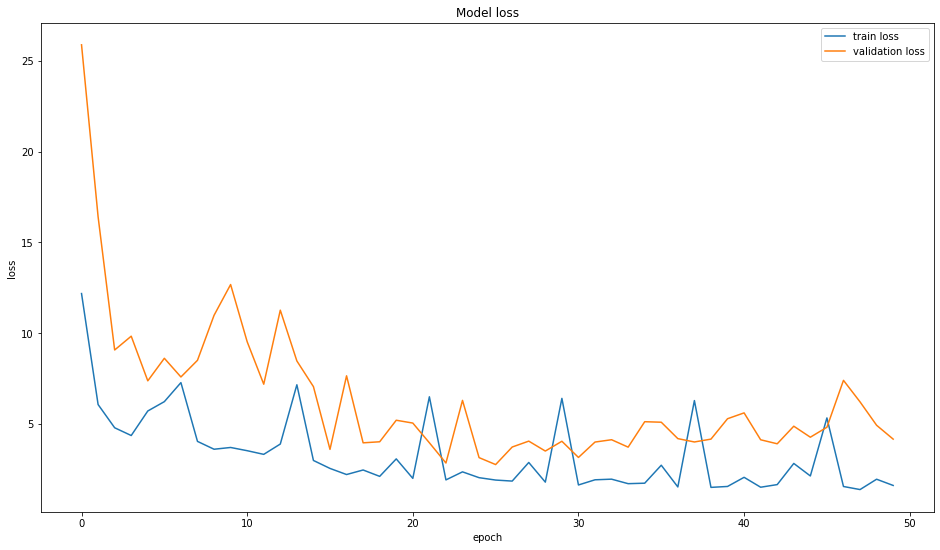

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

In [ ]:
x_test_single.shape, y_test_single.shape

((145275, 30, 77), (145275, 1))

In [ ]:
pred = mape_model.predict(x_test_single)

No handles with labels found to put in legend.


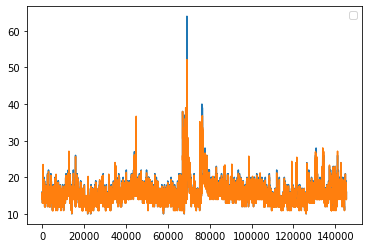

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


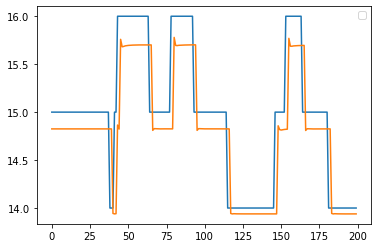

In [ ]:
plt.plot(y_test_single[:200])
plt.plot(pred[:200])
plt.legend()
plt.show()

In [ ]:
max(pred), min(pred)

(array([52.15186], dtype=float32), array([10.083434], dtype=float32))

### 2. RMSE, MAE, MSE

- rmse

In [ ]:
with tf.device('/device:GPU:0'):
  rmse_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  rmse_model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
  rmse_model.summary() 


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 30, 400)          444800    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 30, 128)           51328     
                                                                 
 bidirectional_5 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               51328     
                                                                 
 dense_10 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = rmse_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)


Epoch 1/50
200/200 [==============================] - 12s 31ms/step - loss: 7.6129 - rmse: 2.7591 - val_loss: 49.0117 - val_rmse: 7.0008
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 2.1260 - rmse: 1.4581 - val_loss: 20.0191 - val_rmse: 4.4743
Epoch 3/50
200/200 [==============================] - 5s 24ms/step - loss: 2.0197 - rmse: 1.4211 - val_loss: 22.2164 - val_rmse: 4.7134
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 1.0195 - rmse: 1.0097 - val_loss: 15.4903 - val_rmse: 3.9358
Epoch 5/50
200/200 [==============================] - 5s 24ms/step - loss: 8.6061 - rmse: 2.9336 - val_loss: 7.1471 - val_rmse: 2.6734
Epoch 6/50
200/200 [==============================] - 5s 25ms/step - loss: 13.2164 - rmse: 3.6354 - val_loss: 45.0540 - val_rmse: 6.7122
Epoch 7/50
200/200 [==============================] - 5s 25ms/step - loss: 14.7368 - rmse: 3.8389 - val_loss: 9.5441 - val_rmse: 3.0893
Epoch 8/50
200/200 [===========================

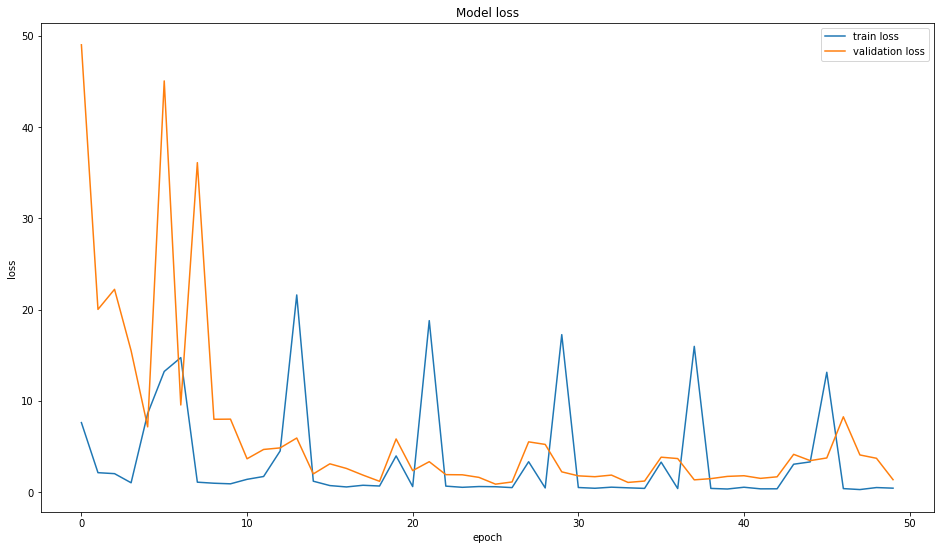

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = rmse_model.predict(x_test_single)


No handles with labels found to put in legend.


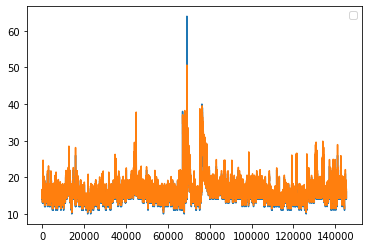

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


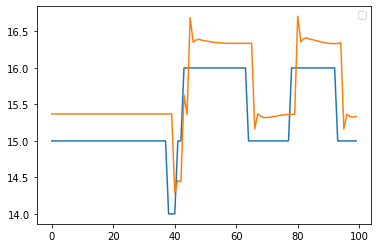

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()

In [ ]:
max(pred), min(pred)

(array([50.668858], dtype=float32), array([10.383175], dtype=float32))

- mae

In [ ]:
with tf.device('/device:GPU:0'):
  mae_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  mae_model.compile(optimizer='adam',loss=tf.keras.losses.MeanAbsoluteError(), metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae')])
  mae_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 30, 400)          444800    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_7 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 400)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               51328     
                                                                 
 dense_14 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = mae_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)

Epoch 1/50
200/200 [==============================] - 12s 31ms/step - loss: 1.7236 - mae: 1.7236 - val_loss: 5.9898 - val_mae: 5.9898
Epoch 2/50
200/200 [==============================] - 5s 24ms/step - loss: 1.4937 - mae: 1.4937 - val_loss: 3.6930 - val_mae: 3.6930
Epoch 3/50
200/200 [==============================] - 5s 24ms/step - loss: 1.0794 - mae: 1.0794 - val_loss: 3.6189 - val_mae: 3.6189
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 0.7407 - mae: 0.7407 - val_loss: 2.0050 - val_mae: 2.0050
Epoch 5/50
200/200 [==============================] - 5s 24ms/step - loss: 1.2184 - mae: 1.2184 - val_loss: 1.7784 - val_mae: 1.7784
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 1.3967 - mae: 1.3967 - val_loss: 4.3573 - val_mae: 4.3573
Epoch 7/50
200/200 [==============================] - 5s 24ms/step - loss: 1.6976 - mae: 1.6976 - val_loss: 1.8758 - val_mae: 1.8758
Epoch 8/50
200/200 [==============================] - 

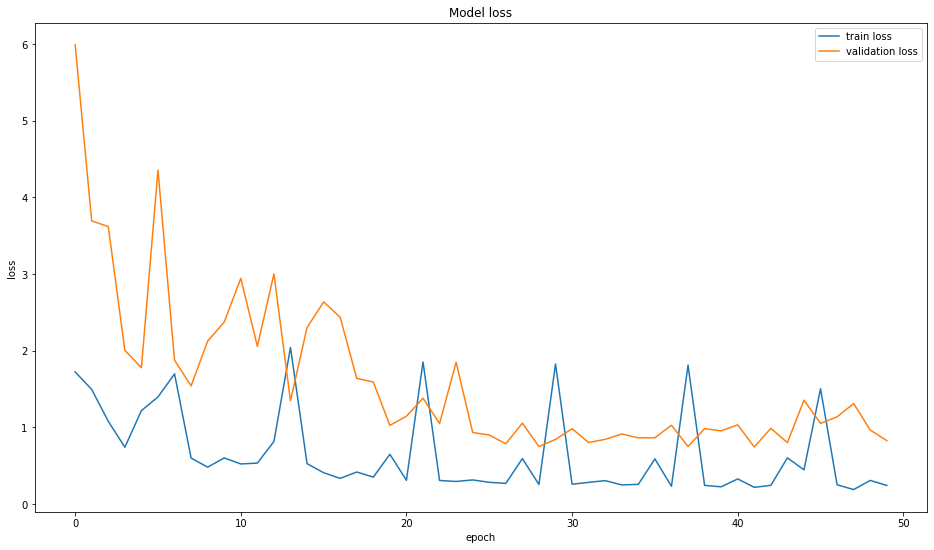

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = mae_model.predict(x_test_single)

No handles with labels found to put in legend.


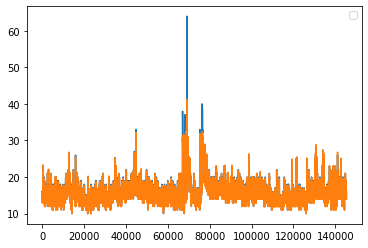

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


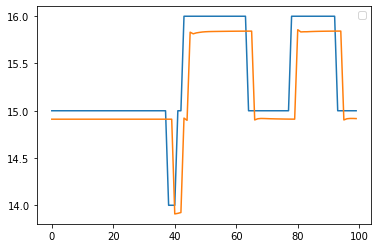

(array([41.208736], dtype=float32), array([9.887461], dtype=float32))

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()
max(pred), min(pred)

- mse

In [ ]:
with tf.device('/device:GPU:0'):
  mse_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  mse_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  mse_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 30, 400)          444800    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_9 (Bidirectio  (None, 400)              526400    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 400)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               51328     
                                                                 
 dense_18 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = mse_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)


Epoch 1/50
200/200 [==============================] - 12s 32ms/step - loss: 8.5536 - mse: 8.5536 - val_loss: 36.4986 - val_mse: 36.4986
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 6.0734 - mse: 6.0734 - val_loss: 33.8741 - val_mse: 33.8741
Epoch 3/50
200/200 [==============================] - 5s 25ms/step - loss: 5.9265 - mse: 5.9265 - val_loss: 40.3572 - val_mse: 40.3572
Epoch 4/50
200/200 [==============================] - 5s 25ms/step - loss: 4.6327 - mse: 4.6327 - val_loss: 41.2364 - val_mse: 41.2364
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 12.0942 - mse: 12.0942 - val_loss: 29.9414 - val_mse: 29.9414
Epoch 6/50
200/200 [==============================] - 5s 25ms/step - loss: 18.5326 - mse: 18.5326 - val_loss: 191.6434 - val_mse: 191.6434
Epoch 7/50
200/200 [==============================] - 5s 25ms/step - loss: 22.8975 - mse: 22.8975 - val_loss: 23.9863 - val_mse: 23.9863
Epoch 8/50
200/200 [==========================

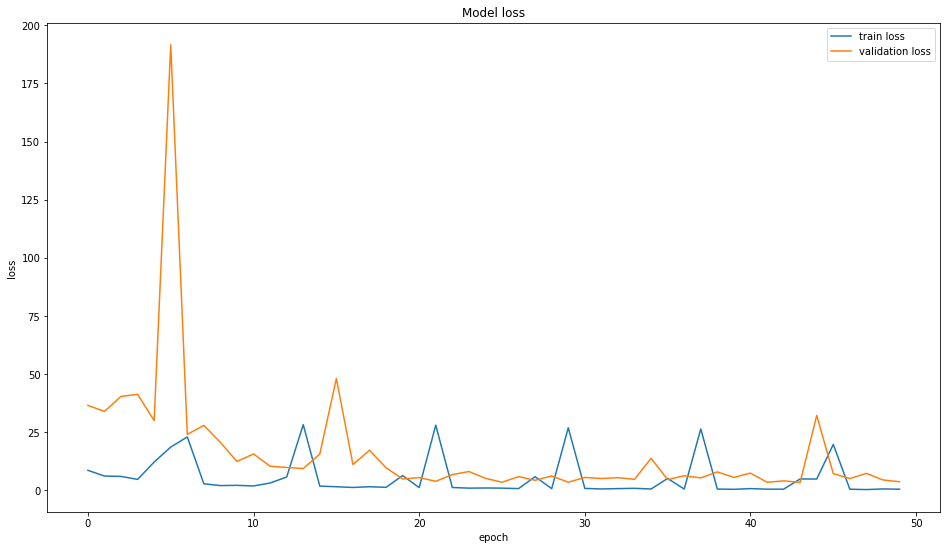

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = mse_model.predict(x_test_single)

No handles with labels found to put in legend.


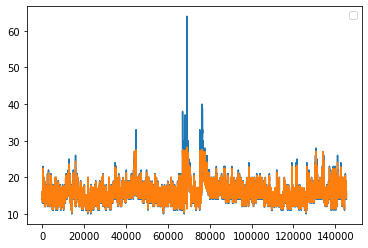

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


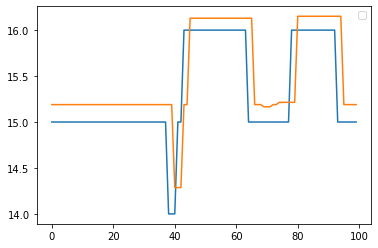

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()

In [ ]:
max(pred), min(pred)

(array([28.247154], dtype=float32), array([10.328188], dtype=float32))

### 3. SMAPE

In [ ]:
# Import Keras backend
import tensorflow.keras.backend as K

# Define SMAPE loss function
def smape_loss(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(tf.cast(K.abs(y_true), dtype='float32') + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_pred - tf.cast(K.abs(y_true), dtype='float32')) / summ * 2.0
    return smape

In [ ]:
with tf.device('/device:GPU:0'):
  smape_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  smape_model.compile(optimizer='adam',loss=smape_loss)#, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])
  smape_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 30, 400)          444800    
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_11 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 400)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               51328     
                                                                 
 dense_22 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = smape_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)

Epoch 1/50
200/200 [==============================] - 12s 31ms/step - loss: 0.1598 - val_loss: 0.2870
Epoch 2/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0740 - val_loss: 0.1321
Epoch 3/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0552 - val_loss: 0.1347
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0458 - val_loss: 0.0914
Epoch 5/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0603 - val_loss: 0.0559
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0632 - val_loss: 0.1022
Epoch 7/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0717 - val_loss: 0.0833
Epoch 8/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0381 - val_loss: 0.1446
Epoch 9/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0359 - val_loss: 0.1002
Epoch 10/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0381 - val_l

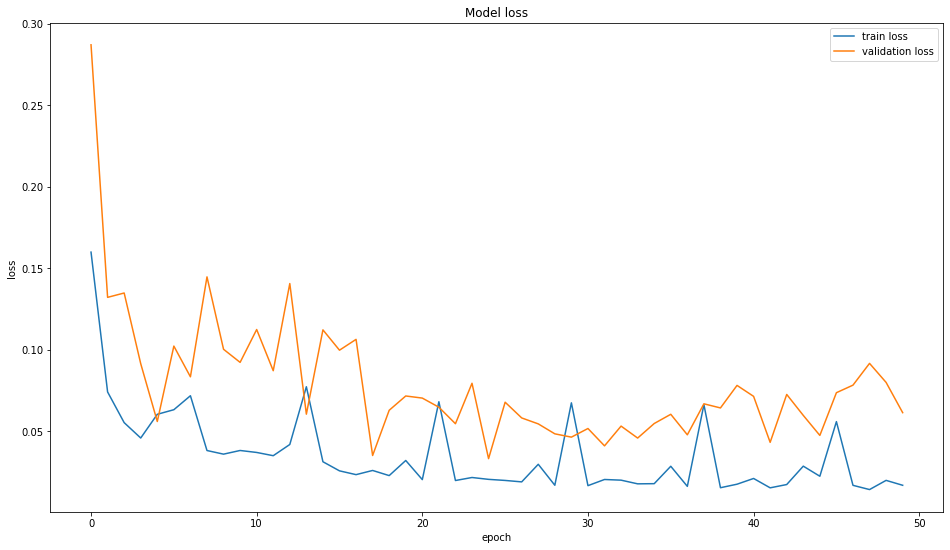

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = smape_model.predict(x_test_single)

No handles with labels found to put in legend.


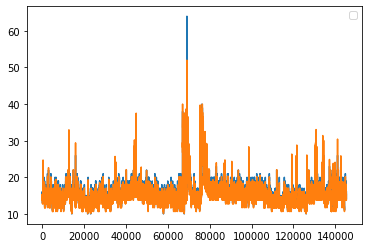

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


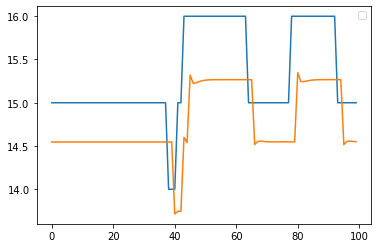

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()

In [ ]:
max(pred), min(pred)

(array([51.990215], dtype=float32), array([10.070755], dtype=float32))

### 4. KLD

In [ ]:
with tf.device('/device:GPU:0'):
  kld_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  kld_model.compile(optimizer='adam',loss=tf.keras.losses.KLDivergence())#, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])
  kld_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 30, 400)          444800    
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_13 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 400)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               51328     
                                                                 
 dense_26 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = kld_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)


Epoch 1/50
200/200 [==============================] - 12s 31ms/step - loss: 0.0689 - val_loss: 0.1172
Epoch 2/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - val_loss: 0.1172
Epoch 3/50
200/200 [==============================] - 5s 24ms/step - loss: 3.3593e-04 - val_loss: 0.0000e+00
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/50
200/200 [==============================] - 5s 25ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
200/200 [==============================] - 5s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/50
200/200 [=========

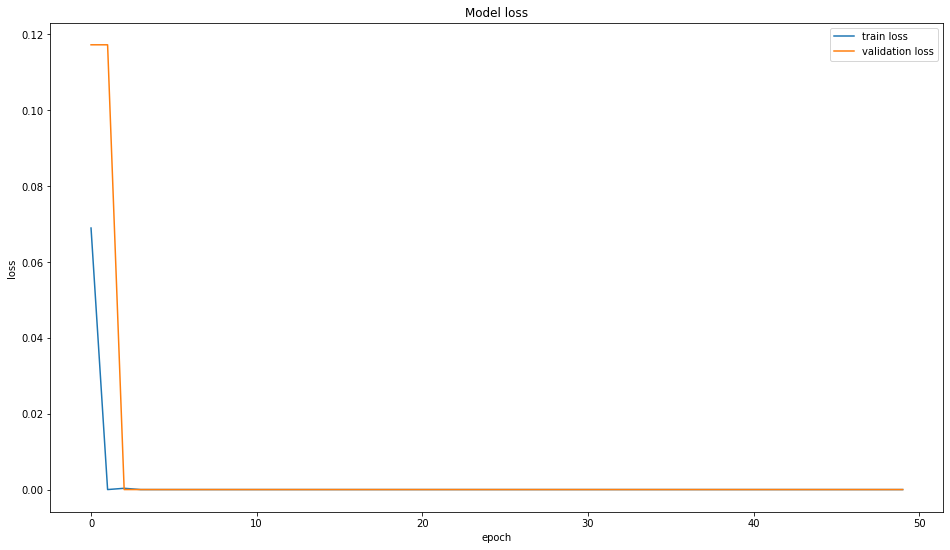

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = kld_model.predict(x_test_single)

No handles with labels found to put in legend.


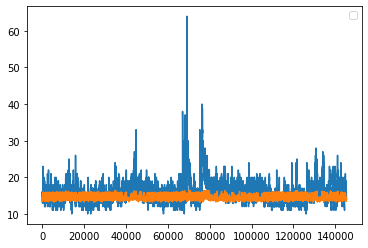

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


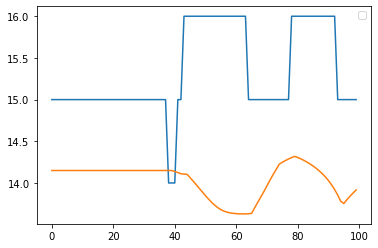

(array([16.36337], dtype=float32), array([13.225625], dtype=float32))

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()
max(pred), min(pred)

### 5. Huber

In [ ]:
with tf.device('/device:GPU:0'):
  huber_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  huber_model.compile(optimizer='adam',loss=tf.keras.losses.Huber())#, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])
  huber_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_14 (Bidirecti  (None, 30, 400)          444800    
 onal)                                                           
                                                                 
 dense_28 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_15 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 400)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               51328     
                                                                 
 dense_30 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = huber_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)

Epoch 1/50
200/200 [==============================] - 12s 31ms/step - loss: 1.3500 - val_loss: 5.3378
Epoch 2/50
200/200 [==============================] - 5s 25ms/step - loss: 0.8607 - val_loss: 2.4614
Epoch 3/50
200/200 [==============================] - 5s 25ms/step - loss: 0.4445 - val_loss: 2.2652
Epoch 4/50
200/200 [==============================] - 5s 25ms/step - loss: 0.3543 - val_loss: 1.4661
Epoch 5/50
200/200 [==============================] - 5s 25ms/step - loss: 0.8057 - val_loss: 1.0321
Epoch 6/50
200/200 [==============================] - 5s 25ms/step - loss: 1.0035 - val_loss: 6.2995
Epoch 7/50
200/200 [==============================] - 5s 25ms/step - loss: 1.3228 - val_loss: 1.1615
Epoch 8/50
200/200 [==============================] - 5s 25ms/step - loss: 0.2572 - val_loss: 2.2852
Epoch 9/50
200/200 [==============================] - 5s 25ms/step - loss: 0.1904 - val_loss: 1.3422
Epoch 10/50
200/200 [==============================] - 5s 25ms/step - loss: 0.2669 - val_l

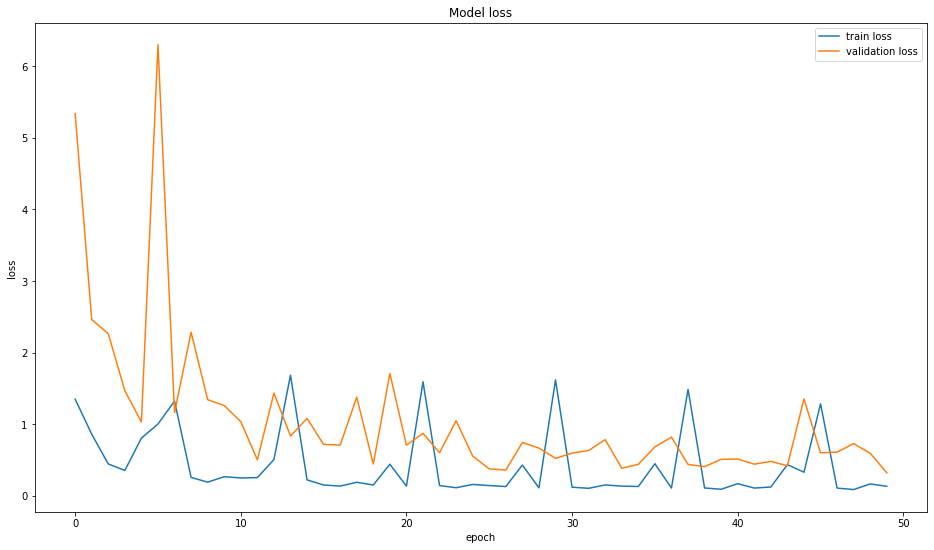

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = huber_model.predict(x_test_single)

No handles with labels found to put in legend.


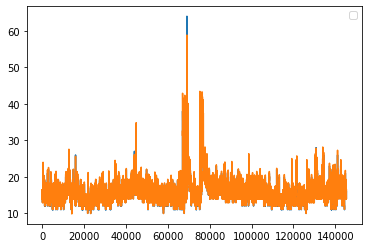

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


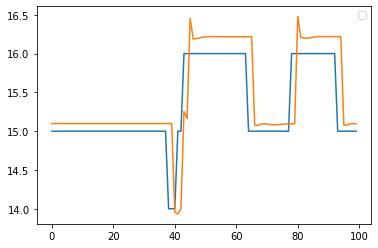

(array([58.853165], dtype=float32), array([9.850264], dtype=float32))

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()
max(pred), min(pred)


### 6. Logcosh

- logcosh

In [ ]:
with tf.device('/device:GPU:0'):
  lc_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  lc_model.compile(optimizer='sgd',loss=tf.keras.losses.LogCosh())#, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')])
  lc_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_16 (Bidirecti  (None, 30, 400)          444800    
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_17 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 400)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               51328     
                                                                 
 dense_34 (Dense)            (None, 64)               

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = lc_model.fit(train_data_single,epochs=50,steps_per_epoch=200,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)


Epoch 1/50
200/200 [==============================] - 12s 34ms/step - loss: 2.6396 - val_loss: 7.2658
Epoch 2/50
200/200 [==============================] - 5s 24ms/step - loss: 1.0139 - val_loss: 2.9801
Epoch 3/50
200/200 [==============================] - 5s 24ms/step - loss: 0.8659 - val_loss: 5.3723
Epoch 4/50
200/200 [==============================] - 5s 24ms/step - loss: 0.7871 - val_loss: 2.8646
Epoch 5/50
200/200 [==============================] - 5s 24ms/step - loss: 1.3474 - val_loss: 3.4340
Epoch 6/50
200/200 [==============================] - 5s 24ms/step - loss: 1.5018 - val_loss: 4.1473
Epoch 7/50
200/200 [==============================] - 5s 24ms/step - loss: 2.2581 - val_loss: 1.7544
Epoch 8/50
200/200 [==============================] - 5s 24ms/step - loss: 0.6630 - val_loss: 3.9973
Epoch 9/50
200/200 [==============================] - 5s 24ms/step - loss: 0.3794 - val_loss: 2.8033
Epoch 10/50
200/200 [==============================] - 5s 24ms/step - loss: 0.4919 - val_l

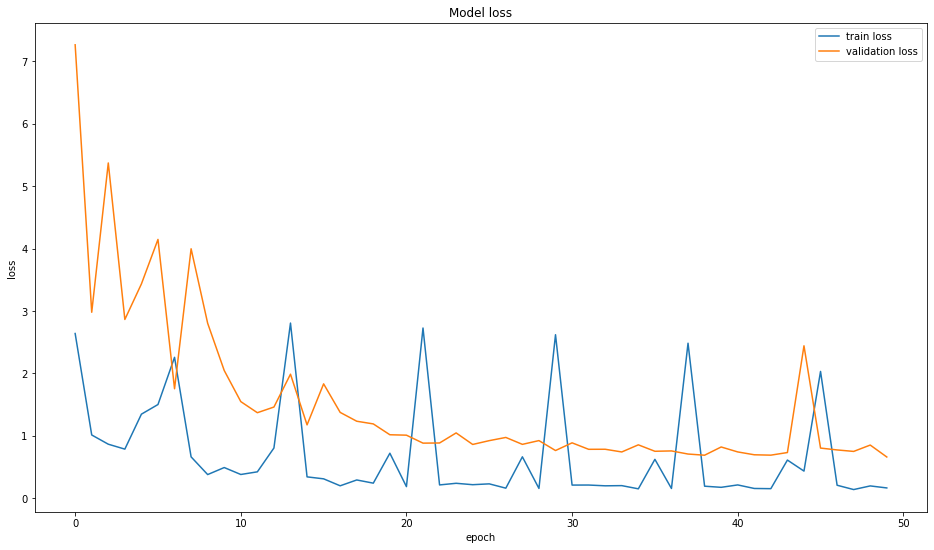

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = lc_model.predict(x_test_single)

No handles with labels found to put in legend.


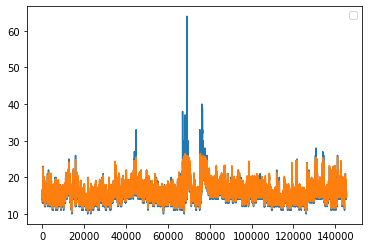

In [ ]:
plt.plot(y_test_single)
plt.plot(pred)
plt.legend()
plt.show()

No handles with labels found to put in legend.


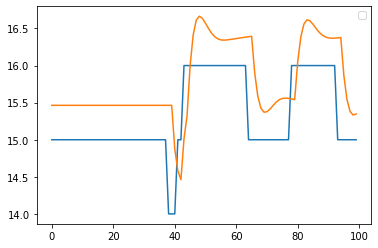

(array([26.450867], dtype=float32), array([10.484209], dtype=float32))

In [ ]:
plt.plot(y_test_single[:100])
plt.plot(pred[:100])
plt.legend()
plt.show()
max(pred), min(pred)

# 다항 분류

### 1. Categorical cross-entropy
- 정확도 너무 낮고 카테고리 너무 많아서 탈락

In [ ]:
with tf.device('/device:GPU:0'):
  cce_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_single.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(units=STEP),
  ])
  #lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
  cce_model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])
  cce_model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_30 (Bidirecti  (None, 30, 400)          481600    
 onal)                                                           
                                                                 
 dense_60 (Dense)            (None, 30, 128)           51328     
                                                                 
 bidirectional_31 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 400)               0         
                                                                 
 dense_61 (Dense)            (None, 128)               51328     
                                                                 
 dense_62 (Dense)            (None, 64)              

In [ ]:
with tf.device('/device:GPU:0'):
  model_path = 'LSTM_Multivariate_real.h5'
  early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_mape', min_delta=0, patience=15, verbose=1, mode='min')
  checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_mape', save_best_only=True, mode='min', verbose=0)
  callbacks=[early_stopings,checkpoint]
  history = cce_model.fit(train_data_single,epochs=50,steps_per_epoch=50,validation_data=val_data_single,validation_steps=20,verbose=1,callbacks=callbacks, shuffle=False)

Epoch 1/50
48/50 [===========================>..] - ETA: 0s - loss: 1.3144e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 9s 61ms/step - loss: 1.3147e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 1.3134e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.3134e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 3/50
49/50 [============================>.] - ETA: 0s - loss: 1.5644e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.5654e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 4/50
48/50 [===========================>..] - ETA: 0s - loss: 1.5551e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 1s 30ms/step - loss: 1.5575e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 1.6636e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.6636e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 6/50
49/50 [============================>.] - ETA: 0s - loss: 1.8956e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 1s 30ms/step - loss: 1.9022e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 7/50
49/50 [============================>.] - ETA: 0s - loss: 1.7921e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.7956e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 8/50
49/50 [============================>.] - ETA: 0s - loss: 1.7333e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.7348e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 9/50
48/50 [===========================>..] - ETA: 0s - loss: 1.6359e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 1s 30ms/step - loss: 1.6281e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 1.5286e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.5286e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 11/50
49/50 [============================>.] - ETA: 0s - loss: 1.5396e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 1s 30ms/step - loss: 1.5407e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 12/50
49/50 [============================>.] - ETA: 0s - loss: 1.6374e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 1s 30ms/step - loss: 1.6369e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 13/50
48/50 [===========================>..] - ETA: 0s - loss: 1.8315e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 1s 30ms/step - loss: 1.8259e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 14/50
49/50 [============================>.] - ETA: 0s - loss: 1.6051e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.6039e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 15/50
49/50 [============================>.] - ETA: 0s - loss: 1.5989e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.5968e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 16/50
49/50 [============================>.] - ETA: 0s - loss: 1.6297e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.6277e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 2.1162e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 2.1162e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 1.7155e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.7155e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 1.8222e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.8222e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 20/50
49/50 [============================>.] - ETA: 0s - loss: 1.9803e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.9769e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 21/50
48/50 [===========================>..] - ETA: 0s - loss: 1.6913e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.6874e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 22/50
49/50 [============================>.] - ETA: 0s - loss: 1.6212e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.6202e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 23/50
48/50 [===========================>..] - ETA: 0s - loss: 1.6429e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.6387e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 2.5115e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 2.5115e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 25/50
48/50 [===========================>..] - ETA: 0s - loss: 3.0310e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 2.9896e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 26/50
50/50 [==============================] - ETA: 0s - loss: 1.8601e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.8601e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 27/50
48/50 [===========================>..] - ETA: 0s - loss: 1.8457e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.8482e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 28/50
50/50 [==============================] - ETA: 0s - loss: 1.8214e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.8214e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 29/50
50/50 [==============================] - ETA: 0s - loss: 1.8032e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.8032e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 30/50
50/50 [==============================] - ETA: 0s - loss: 1.8218e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.8218e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 31/50
49/50 [============================>.] - ETA: 0s - loss: 2.0167e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 2.0226e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 32/50
50/50 [==============================] - ETA: 0s - loss: 1.5331e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.5331e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 33/50
50/50 [==============================] - ETA: 0s - loss: 1.3253e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.3253e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 34/50
50/50 [==============================] - ETA: 0s - loss: 1.4706e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.4706e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 35/50
49/50 [============================>.] - ETA: 0s - loss: 1.5875e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.5879e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 36/50
49/50 [============================>.] - ETA: 0s - loss: 1.6269e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 30ms/step - loss: 1.6277e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 37/50
49/50 [============================>.] - ETA: 0s - loss: 1.7250e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.7356e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 38/50
50/50 [==============================] - ETA: 0s - loss: 1.9516e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.9516e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 39/50
49/50 [============================>.] - ETA: 0s - loss: 1.7419e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.7403e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 40/50
50/50 [==============================] - ETA: 0s - loss: 1.6726e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 34ms/step - loss: 1.6726e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 41/50
49/50 [============================>.] - ETA: 0s - loss: 1.4877e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 35ms/step - loss: 1.4871e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 42/50
50/50 [==============================] - ETA: 0s - loss: 1.5933e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 35ms/step - loss: 1.5933e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 43/50
49/50 [============================>.] - ETA: 0s - loss: 1.5653e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 33ms/step - loss: 1.5685e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 44/50
50/50 [==============================] - ETA: 0s - loss: 1.8239e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.8239e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 45/50
50/50 [==============================] - ETA: 0s - loss: 1.6576e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.6576e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 46/50
49/50 [============================>.] - ETA: 0s - loss: 1.5603e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 32ms/step - loss: 1.5618e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 47/50
49/50 [============================>.] - ETA: 0s - loss: 1.6279e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.6290e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 48/50
48/50 [===========================>..] - ETA: 0s - loss: 1.7667e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.8017e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 49/50
49/50 [============================>.] - ETA: 0s - loss: 2.0291e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 2.0237e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00
Epoch 50/50
50/50 [==============================] - ETA: 0s - loss: 1.7728e-06 - acc: 0.0000e+00WARNING:tensorflow:Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: loss,acc,val_loss,val_acc


50/50 [==============================] - 2s 31ms/step - loss: 1.7728e-06 - acc: 0.0000e+00 - val_loss: 2.3553e-06 - val_acc: 0.0000e+00


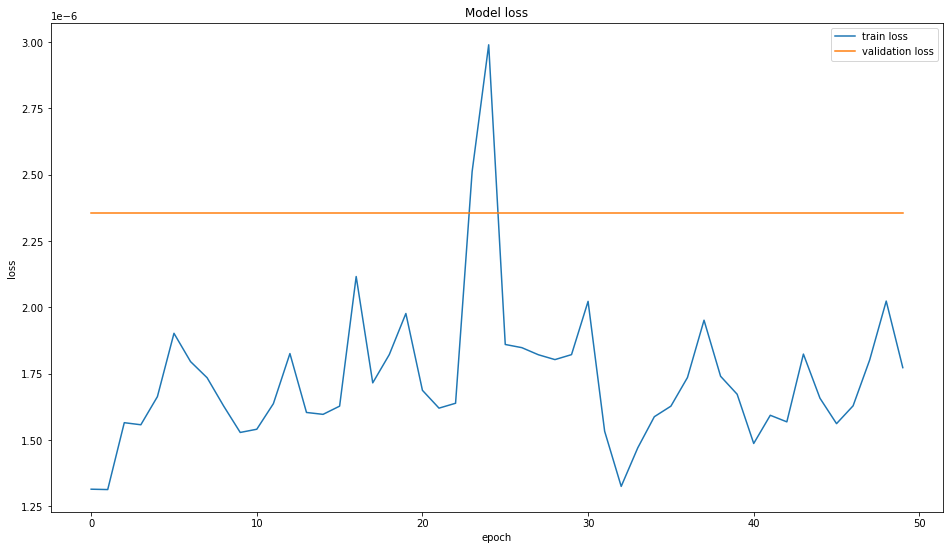

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
mul_df = mul_df.fillna(0)
x_test_single, y_test_single = multivariate_data(mul_df.iloc[:,~mul_df.columns.isin(['pods'])].values, mul_df.iloc[:,mul_df.columns.isin(['pods'])].values, 
                                                   test_idx, total_idx, past_history, future_target, STEP, single_step=True)

pred = cce_model.predict(x_test_single)

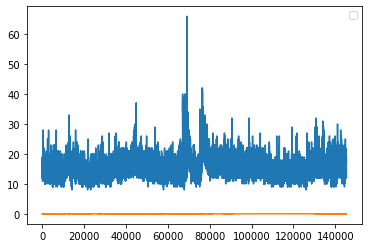

In [ ]:
plt.plot(mul_df['pods'].iloc[test_idx:total_idx].reset_index(drop=True))
plt.plot(pred)
plt.legend()
plt.show()

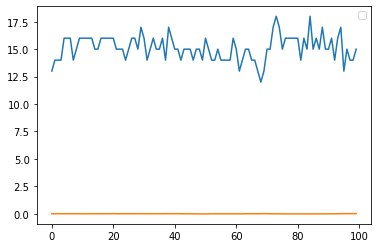

In [ ]:
plt.plot(mul_df['pods'].iloc[test_idx:test_idx+100].reset_index(drop=True))
plt.plot(pred[:100])
plt.legend()
plt.show()

In [ ]:
max(pred), min(pred)

(array([0.03506624], dtype=float32), array([-0.02892474], dtype=float32))

# 그냥 순환 신경망 하나 데려옴

- [참고](https://ohikendoit.github.io/time-series/2020/05/24/TimeSeriesForecasting_1.html)

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/AI-HPA_Model/data/log_df_pods_slow.csv").drop(["Unnamed: 0"], axis=1)

# 방법1
- 차이에 0.7을 곱한 값에 버림한 값을 사용
- 9->10이면 [9 + 1 * 0.7] = 9이므로 2차이가 나야 1이 증가할 수 있다(+[1.4])

-> 잘 안 됨... 너무 그거라서 안 되는 느낌이라 이걸 부드러운 곡선으로 만들어보고 싶..음.. 그래도 안 될 듯



In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, single_step=False):
    data=[]
    labels=[]
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        #Reshape data from (history_size,) to (history_size,1)
        data.append(np.reshape(dataset[indices], (history_size,1)))

        if single_step:
            labels.append(dataset[i+target_size])
        else:
            labels.append(dataset[i:i+target_size])
            
    return np.array(data), np.array(labels)

In [ ]:
TRAIN_SPLIT = 2000000
tf.random.set_seed(13)

In [ ]:
uni_data = df['pods']
uni_data.index = df.index
uni_data.head()

0     9
1     9
2     9
3    10
4    11
Name: pods, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5fe86b9a10>],
      dtype=object)

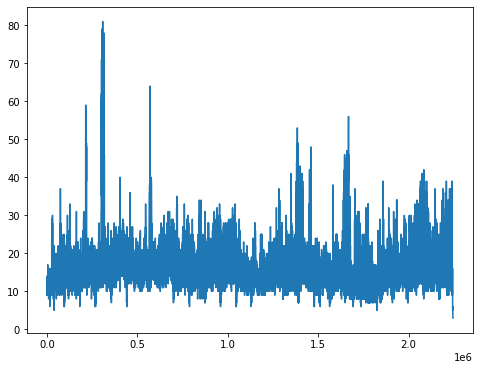

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
univariate_past_history = 5
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target, single_step=True)

In [ ]:
len(x_train_uni), len(x_val_uni)

(1999995, 245299)

In [ ]:
print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[ 9]
 [ 9]
 [ 9]
 [10]
 [11]]

 Target temperature to predict
[11]


In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
        
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
with tf.device('/device:GPU:0'):
  simple_lstm_model = tf.keras.models.Sequential([
      Bidirectional(LSTM(200, return_sequences=True), input_shape=x_train_uni.shape[-2:]),
      Dense(128, activation='tanh'),
      Bidirectional(tf.keras.layers.LSTM(200)),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='tanh'),
      Dense(128, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(128, activation='tanh'),
      Dense(128, activation='tanh'),
      tf.keras.layers.Dropout(0.4),
      Dense(units=1),
  ])

  simple_lstm_model.compile(optimizer='adam', loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])#tf.keras.optimizers.RMSprop(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.MeanSquaredError(name='mse')]
  simple_lstm_model.summary() 


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirecti  (None, 5, 400)           323200    
 onal)                                                           
                                                                 
 dense_36 (Dense)            (None, 5, 128)            51328     
                                                                 
 bidirectional_19 (Bidirecti  (None, 400)              526400    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 400)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               51328     
                                                                 
 dense_38 (Dense)            (None, 128)              

In [ ]:
EVALUATION_INTERVAL = 200 #데이터셋 크기가 큼으로 시간을 절약하기위해서 각 EPOCH는 200스탭만 실시합니다
EPOCHS = 100
model_path = 'model.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
hist=simple_lstm_model.fit(train_univariate, epochs=EPOCHS, validation_data=val_univariate, validation_steps=50, verbose=1, callbacks=callbacks, steps_per_epoch=EVALUATION_INTERVAL)

Epoch 1/100
200/200 [==============================] - 9s 18ms/step - loss: 6.6323 - rmse: 2.5753 - val_loss: 10.2535 - val_rmse: 3.2021
Epoch 2/100
200/200 [==============================] - 2s 11ms/step - loss: 7.2785 - rmse: 2.6979 - val_loss: 9.0451 - val_rmse: 3.0075
Epoch 3/100
200/200 [==============================] - 2s 11ms/step - loss: 6.6365 - rmse: 2.5761 - val_loss: 7.7144 - val_rmse: 2.7775
Epoch 4/100
200/200 [==============================] - 2s 10ms/step - loss: 5.7964 - rmse: 2.4076 - val_loss: 9.1643 - val_rmse: 3.0273
Epoch 5/100
200/200 [==============================] - 2s 10ms/step - loss: 19.8285 - rmse: 4.4529 - val_loss: 8.0777 - val_rmse: 2.8421
Epoch 6/100
200/200 [==============================] - 2s 10ms/step - loss: 39.1259 - rmse: 6.2551 - val_loss: 93.3505 - val_rmse: 9.6618
Epoch 7/100
200/200 [==============================] - 2s 11ms/step - loss: 36.1829 - rmse: 6.0152 - val_loss: 0.7756 - val_rmse: 0.8807
Epoch 8/100
200/200 [======================

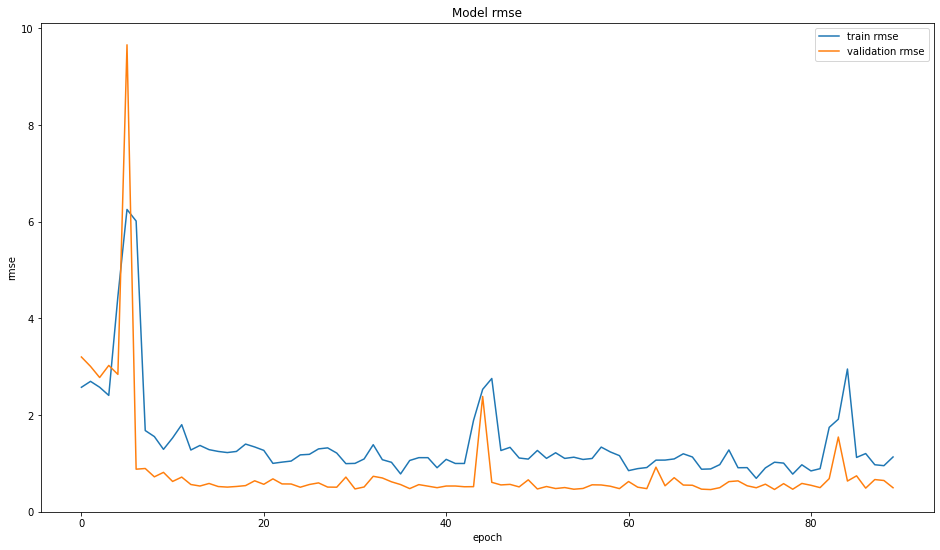

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['rmse'])
plt.plot(hist.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

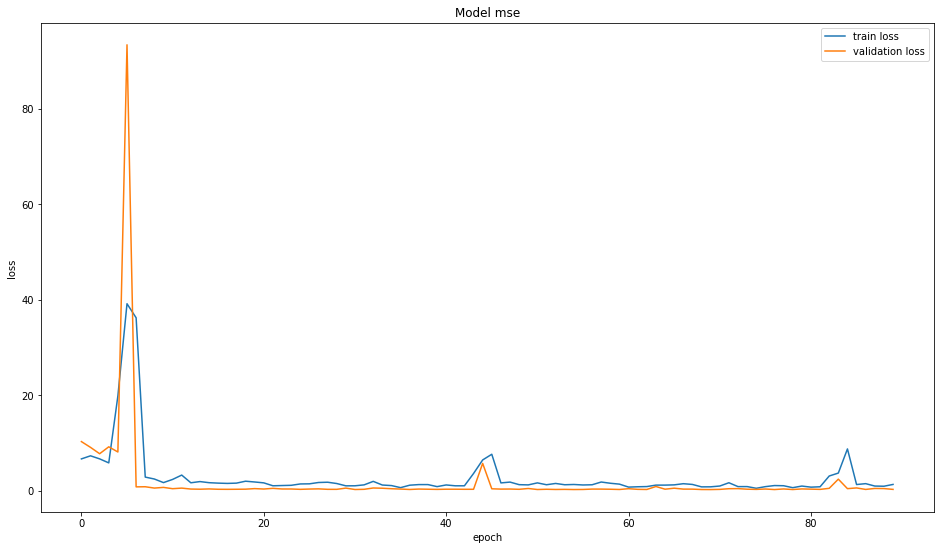

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

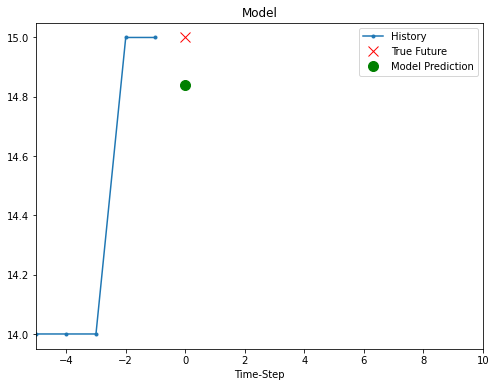

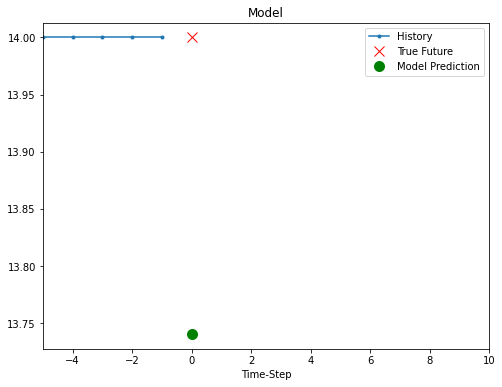

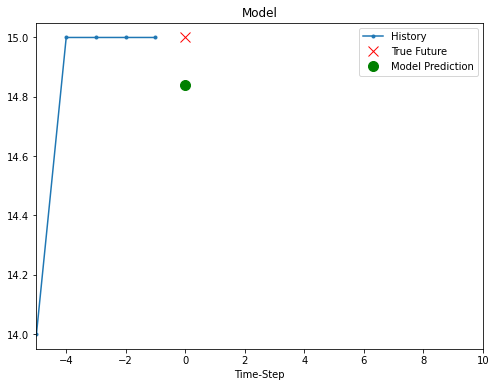

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Model')
    plot.show()

In [ ]:
!pip install pyyaml h5py  # HDF5 포맷으로 모델을 저장하기 위해서 필요합니다!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.2


In [ ]:
simple_lstm_model.save('/content/drive/MyDrive/AI-HPA_Model/data/simple_lstm_model3.pkl')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-HPA_Model/data/simple_lstm_model3.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-HPA_Model/data/simple_lstm_model3.pkl/assets


In [ ]:
simple_lstm_model.save('/content/drive/MyDrive/AI-HPA_Model/data/simple_lstm_model3.h5')